# Compute input datasets for sedflux generation from model output

Generate a set of files for each of the following groups:

- POC-FLUX: ['POC_FLUX_IN']
- Velocity: ['UVEL', 'VVEL']

Steps:
1. Produce files on a set of source grids
1. Optionally generate on a set of destination grids


In [1]:
%matplotlib inline
import os
from glob import glob

from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import esmlab
import esmlab_regrid
esmlab.config.set({'regrid.gridfile-directory' : '/glade/work/mclong/esmlab-regrid'});

import pop_tools

import config

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
gridfile_directory = esmlab.config.get('regrid.gridfile-directory')
gridfile_directory

'/glade/work/mclong/esmlab-regrid'

## Build and test horizontal regridding

### Generate SCRIP grid files for each of the supported grids.

Ideally, a regridding workflow would support this in situ.

In [3]:
grids = {
    grid_name: pop_tools.get_grid(grid_name) 
    for grid_name in ['POP_tx0.1v3', 'POP_gx3v7', 'POP_gx1v7']
}

for grid_name, grid in grids.items():    
    scrip_grid_file = f'{gridfile_directory}/{grid_name}.nc'    
    if not os.path.exists(scrip_grid_file):
        print(f'generating {scrip_grid_file}')
        del grid.attrs['region_mask_regions']
        grid.to_netcdf(scrip_grid_file)

### Construct weight file names and ensure they are present

`esmlab_regrid` should support generating weight files, but I am getting and ESMF error about PIO not being available. Probably this requires some `module loads` before launching...but that's not acceptable if that's the case, there should be no dependencies outside of the `conda` environment.

As a workaround, I wrote [esmf_gen_weights_pop2pop.pbs](esmf_gen_weights_pop2pop.pbs) and run this on the batch nodes.

In [4]:
method = 'conservative'
get_key = lambda src, dst: f'{src}_to_{dst}_{method}'    

weight_files = {}
for src, dst in product(grids.keys(), grids.keys()): 
    if src == dst: continue
    key = get_key(src, dst)
    value = f'{gridfile_directory}/weights/{src}_to_{dst}_{method}.nc'
    weight_files[key] = value
    
missing = {k: f for k, f in weight_files.items() if not os.path.exists(f)}
if missing:
    missing_some = True
    print(f'missing weight files:\n{list(missing.keys())}\n\nrun the following:\nqsub < esmf_gen_weights_pop2pop.pbs\n')
else:
    print('all weight files are present')

all weight files are present


In [5]:
#%%bash
# qsub not available from Casper
#qsub < esmf_gen_weights_pop2pop.pbs

### Construct dictionary of horizontal regridding operators

In [6]:
regrid_operator = {}
for src_grid, dst_grid in product(grids.keys(), grids.keys()): 
    if src_grid == dst_grid: continue
    key = get_key(src_grid, dst_grid)
    regrid_operator[key] = esmlab_regrid.regridder(
        name_grid_src=src_grid, 
        name_grid_dst=dst_grid, 
        method=method, 
        overwrite_existing=False
    )
regrid_operator        

{'POP_tx0.1v3_to_POP_gx3v7_conservative': <esmlab_regrid.core.Regridder at 0x2abc2b5b2690>,
 'POP_tx0.1v3_to_POP_gx1v7_conservative': <esmlab_regrid.core.Regridder at 0x2abbec3f93d0>,
 'POP_gx3v7_to_POP_tx0.1v3_conservative': <esmlab_regrid.core.Regridder at 0x2abbec403f90>,
 'POP_gx3v7_to_POP_gx1v7_conservative': <esmlab_regrid.core.Regridder at 0x2abbec405050>,
 'POP_gx1v7_to_POP_tx0.1v3_conservative': <esmlab_regrid.core.Regridder at 0x2abbec403a50>,
 'POP_gx1v7_to_POP_gx3v7_conservative': <esmlab_regrid.core.Regridder at 0x2abc072baf90>}

"Test" regridding with `TAREA` field from the grid. Here I am just aiming to pass a sniff test: does the remapped field look right.

What's a better way to test this? The differing land-mask will mean integrals don't match....


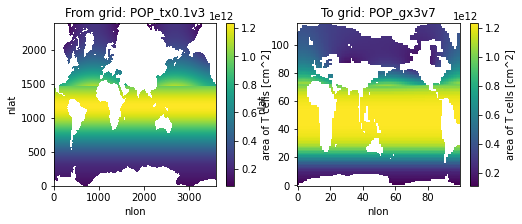

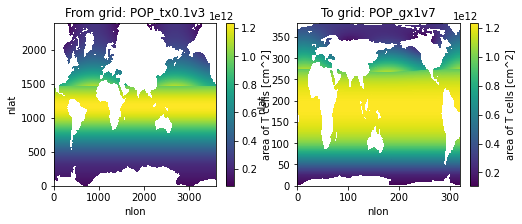

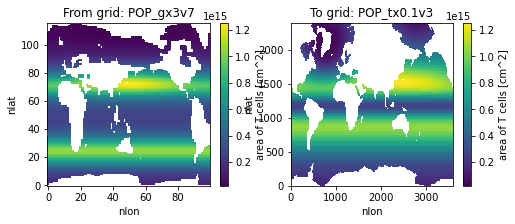

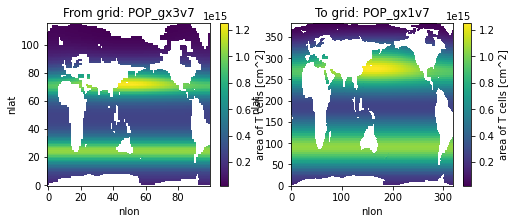

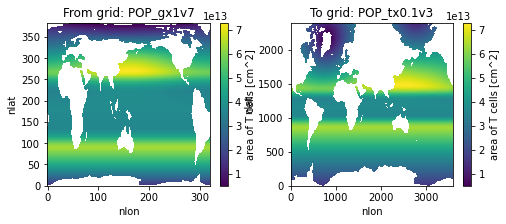

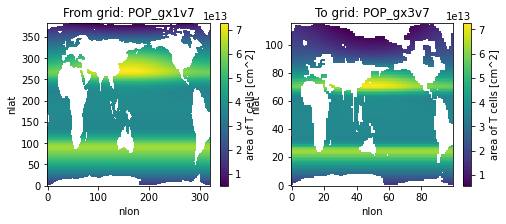

In [17]:
for src_grid, dst_grid in product(grids.keys(), grids.keys()): 
    if src_grid == dst_grid: continue
    key = get_key(src_grid, dst_grid)

    da_src = grids[src_grid].TAREA.where(grids[src_grid].KMT > 0)
    
    da_dst = regrid_operator[key](
        da_src,
        renormalize=True, 
        apply_mask=True
    )
    
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(1, 2, 1)
    da_src.plot()
    ax.set_title(f'From grid: {src_grid}')
    ax = fig.add_subplot(1, 2, 2)
    da_dst.plot()
    ax.set_title(f'To grid: {dst_grid}')

### Define vertical interpolation

Generate pseudo-data for each grid, a DataArray with 0:km-1 in each column

In [8]:
da_test_src = {}
for src_grid, grid in grids.items():
    nk, nj, ni = len(grid.z_t), len(grid.nlat), len(grid.nlon)
    k = xr.DataArray(np.arange(0, nk), dims=('z_t'), coords={'z_t': grids[src_grid].z_t})
    ones = xr.DataArray(
        np.ones((nk, nj, ni)), 
        dims=('z_t', 'nlat', 'nlon'), 
        coords={'z_t': grids[src_grid].z_t}
    )
    
    da_test_src[src_grid] = k * ones 

Define vertical remappiong function and test it in situ

In [9]:
def remap_z_t(da, src_grid, dst_grid):
    """Handle vertical "interpolation", exploiting the fact 
       that the POP vertical coordinates are identical for 
       all grids, except that the hi-res model has 2 extra 
       levels at the bottom. 
    """
    
    grids_60lev = ['POP_gx1v6', 'POP_gx1v7', 'POP_gx3v7']
    grids_62lev = ['POP_tx0.1v3']
    
    new_z_t = pop_tools.get_grid(dst_grid).z_t

    # lo-res ---> lo-res: just return
    if src_grid in grids_60lev and dst_grid in grids_60lev:
        return da.assign_coords({'z_t': new_z_t})
                   
    # hi-res ---> lo-res: return all but the lowest two levels
    elif src_grid in grids_62lev and dst_grid in grids_60lev:
        return da.isel(z_t=slice(0, -2)).assign_coords({'z_t': new_z_t})

    # lo-res ---> hi-res: copy the lowest level down
    elif src_grid in grids_60lev and dst_grid in grids_62lev:
        dao_slab_m2 = da.isel(z_t=-1).assign_coords({'z_t': new_z_t[-2]})
        dao_slab_m1 = da.isel(z_t=-1).assign_coords({'z_t': new_z_t[-1]})
        return xr.concat((da, dao_slab_m2, dao_slab_m1), dim=new_z_t)
    else:
        raise ValueError(f'unknown grid combination: {src_grid} --> {dst_grid}')

        
# unit test: apply remapping and confirm that values match
for src_grid, dst_grid in product(grids.keys(), grids.keys()): 
    if src_grid == dst_grid: 
        continue

    da_src = da_test_src[src_grid]
    
    da_dst = remap_z_t(
        da_src, 
        src_grid,
        dst_grid,
    )
    
    nk_src, nk_dst = len(da_src.z_t), len(da_dst.z_t)

    if nk_src < nk_dst:
        assert (da_src[:, 0, 0] == da_dst[:nk_src, 0, 0]).all()
        assert (da_src[-1, 0, 0] == da_dst[-(nk_dst-nk_src):, 0, 0]).all()        

    elif nk_src > nk_dst:
        assert (da_src[:nk_dst, 0, 0] == da_dst[:, 0, 0]).all()        
    
    else:
        assert (da_dst[:, 0, 0] == da_src[:, 0, 0]).all()

Define a fill procedure based on `pop_tools`. 

First, define a function to generate a 3D mask.

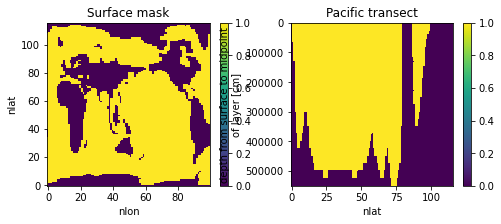

In [14]:
def get_mask(ds_pop):
    required_vars = ['z_t', 'KMT']
    missing_vars = set(required_vars) - set(ds_pop.variables)
    if missing_vars:
        raise ValueError(f'missing required vars:\n {missing_vars}')
    
    nk, nj, ni = len(ds_pop.z_t), len(ds_pop.nlat), len(ds_pop.nlon)

    # make 3D array of 0:km
    zero_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'))
    ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))
    ZERO_TO_KM = (zero_to_km * ONES_3d)

    # mask out cells where k is below KMT
    MASK = ZERO_TO_KM.where(ZERO_TO_KM < ds_pop.KMT)
    MASK = xr.where(MASK.notnull(), True, False)

    return MASK.assign_coords({'z_t': ds_pop.z_t})

MASK = get_mask(grids['POP_gx3v7'])

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 2, 1)
MASK.isel(z_t=0).plot()
h = plt.title('Surface mask')

ax = fig.add_subplot(1, 2, 2)
MASK.isel(nlon=65).plot(yincrease=False)
h = plt.title('Pacific transect')

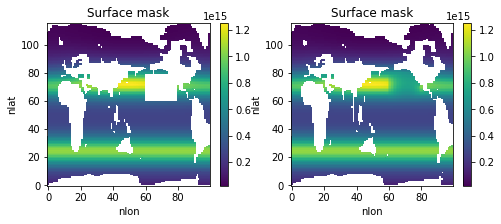

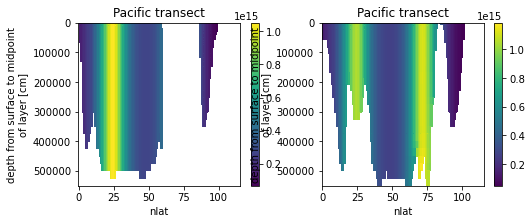

In [37]:
def fill_unmapped_points(da, grid_name):
    """fill unmapped points"""
    
    ds_grid = grids[grid_name]
    MASK = get_mask(ds_grid)
    ltripole = (ds_grid.type == 'tripole')
    
    da_fill = pop_tools.lateral_fill(da.copy(), MASK, ltripole=ltripole)
    
    # propagate values down to fill vertically, if necessary
    unfilled = da_fill.isnull() & (MASK == 1.) 
    if not unfilled.any():
        return da_fill
    
    nk = len(da_fill.z_t)
    for k in range(1, nk):
        da_fill[k, :, :] = xr.where(
            unfilled[k, :, :], 
            da_fill[k-1, :, :], 
            da_fill[k, :, :]
        )    
    return da_fill


grid = 'POP_gx3v7'
test_field = (get_mask(grids[grid]) * grids[grid].TAREA).where(get_mask(grids[grid]) > 0)
test_field[:, 60:80, 60:80] = np.nan
test_field_fill = fill_unmapped_points(test_field, grid)

fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(1, 2, 1)
test_field.isel(z_t=0).plot()
h = plt.title('Surface mask')

ax = fig.add_subplot(1, 2, 2)
test_field_fill.isel(z_t=0).plot()
h = plt.title('Surface mask')


fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(1, 2, 1)
test_field.isel(nlon=65).plot(yincrease=False)
h = plt.title('Pacific transect')
ax = fig.add_subplot(1, 2, 2)
test_field_fill.isel(nlon=60).plot(yincrease=False)
h = plt.title('Pacific transect')



In [84]:
def def ugrid_to_tgrid(arr_ugrid):
    """
    Interpolates values at U points on a B grid to T points.
    """
    with xr.set_options(keep_attrs=True):
        return 0.25 * (
            arr_ugrid +  # j, i
            arr_ugrid.roll(nlat=1, roll_coords=False) + # j-1, i
            arr_ugrid.roll(nlon=1, roll_coords=False) + # j, i-1
            arr_ugrid.roll(nlat=1, nlon=1, roll_coords=False) #j-1, i-1
        )(arr_ugrid):
    """
    Interpolates values at U points on a B grid to T points.
    """
    with xr.set_options(keep_attrs=True):
        return 0.25 * (
            arr_ugrid +  # j, i
            arr_ugrid.roll(nlat=1, roll_coords=False) + # j-1, i
            arr_ugrid.roll(nlon=1, roll_coords=False) + # j, i-1
            arr_ugrid.roll(nlat=1, nlon=1, roll_coords=False) #j-1, i-1
        )

# TODO: Add test

## Get model data and generate zarr archives 

In [85]:
dsets = {}

xr_open = dict(
    combine='nested', 
    concat_dim='time',
    decode_times=False,
    decode_coords=False,
    chunks={'time': 24, 'z_t': 20},
)

var_groups = dict(
    poc_flux=['POC_FLUX_IN'],
    velocity=['UVEL', 'VVEL'],
)

grid_vars = ['TAREA', 'KMT', 'TLONG', 'TLAT', 'ULONG', 'ULAT', 'z_t', 'time', 'time_bound']


def get_dset(var_group, grid):
    """construct a dataset for particular variable group"""
    
    variables = var_groups[var_group]

    key = f'{grid}-{var_group}'
    
    if key in dsets:
        print('returning cached dataset')
        
    else:
        print('generating dataset from files')
        
        if grid == 'POP_tx0.1v3':
            # assume all variables in the same file
            case = 'g.e20.G.TL319_t13.control.001_hfreq'
            droot = f'/glade/campaign/cgd/oce/altuntas/{case}/ocn/hist'
            datestr = '????-??-??'
            files = sorted(glob(f'{droot}/{case}.pop.h.{datestr}.nc'))

            print('DEBUG SETTING: not all files used')
            files = files[:3]
            
            ds = xr.open_mfdataset(files, **xr_open)           
            ds.attrs['input_files'] = ','.join(files)
            
        elif grid == 'POP_gx1v7':
            case = 'b.e21.B1850.f09_g17.CMIP6-piControl.001'
            droot = f'/glade/collections/cdg/timeseries-cmip6/{case}'
            droot = f'{droot}/ocn/proc/tseries/month_1'
            datestr = '060001-069912'

            ds = xr.Dataset()
            input_files = ''
            for v in variables:
                files = f'{droot}/{case}.pop.h.{v}.{datestr}.nc'
                input_files += ','.join(files)+'; '
                dsv = xr.open_dataset(
                    files, 
                    decode_times=False,
                    decode_coords=False,
                    chunks={'time': 24, 'z_t': 20},
                )
                ds = xr.merge((ds, dsv))

            ds.attrs['input_files'] = input_files    
        else:
            raise ValueError(f'unknown grid: {grid}')
        
        # put UVEL and VVEL on T-Grid
        if var_group == 'velocity':
            for v in variables:
                ds[v] = ugrid_to_tgrid(ds[v])

        dsets[key] = ds[variables+grid_vars]
        
    return dsets[key]

        
def proc_var_group(var_group, src_grid, dst_grid=None):
    """Generate output dataset"""

    print('-'*80)
    print(f'{var_group}: {src_grid} --> {dst_grid}')

    if dst_grid is None:
        dst_grid = src_grid

    # get the input dataset
    ds = get_dset(var_group, src_grid)
    variables = var_groups[var_group]
    
    # compute temporal mean
    time_weights = ds.time_bound.diff('d2').squeeze()
    time_total = time_weights.sum()
    wgt = time_weights / time_total
    np.testing.assert_allclose(wgt.sum(), 1.0, rtol=1e-7)

    with xr.set_options(keep_attrs=True):
        ds_src = (ds[variables] * wgt).sum('time').compute()
    
    # return dataset, performing regridding if necesssary
    if src_grid == dst_grid:
        return ds_src
    
    else:       
        ds_dst = xr.Dataset()

        for v in variables:
            # perform lateral regridding
            key = get_key(src_grid, dst_grid)
            da_dst = regrid_operator[key](
                ds_src[v], 
                renormalize=True, 
                apply_mask=True
            )
            
            # perform vertical regridding
            da_dst = remap_z_t(da_dst, src_grid, dst_grid)
            
            # fill missing values left on dst_grid
            da_dst = fill_unmapped_points(da_dst, dst_grid)
            
            # copy DataArray to outgoing Dataset
            ds_dst[v] = da_dst
            
        return ds_dst

In [11]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster()
cluster.scale(36)
cluster

In [12]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.11:42336 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [15]:
var_group_grids = dict(
    poc_flux=[
        ('POP_gx1v7', 'POP_gx1v7'), 
        ('POP_gx1v7', 'POP_tx0.1v3'), 
    ],
    velocity=[
        ('POP_gx1v7', 'POP_gx1v7'), 
        ('POP_tx0.1v3', 'POP_tx0.1v3'), 
        ('POP_tx0.1v3', 'POP_gx1v7'),         
    ],
)

for var_group, src_dst_list in var_group_grids.items():
    for src_grid, dst_grid in src_dst_list:
        file_out = f'{config.dirwork}/{var_group}.{src_grid}_to_{dst_grid}.zarr'
        if not os.path.exists(file_out):
            dso = proc_var_group(var_group, src_grid, dst_grid)
            dso.info()
            print()
            dso.to_zarr(file_out)

--------------------------------------------------------------------------------
poc_flux: POP_gx1v7 --> POP_tx0.1v3
generating dataset from files
xarray.Dataset {
dimensions:
	nlat = 2400 ;
	nlon = 3600 ;
	z_t = 62 ;

variables:
	float64 z_t(z_t) ;
		z_t:units = cm ;
		z_t:long_name = depth from surface to midpoint of layer ;
		z_t:positive = down ;
	float64 POC_FLUX_IN(z_t, nlat, nlon) ;
		POC_FLUX_IN:long_name = POC Flux into Cell ;
		POC_FLUX_IN:units = mmol/m^3 cm/s ;
		POC_FLUX_IN:coordinates = TLONG TLAT z_t time ;
		POC_FLUX_IN:grid_loc = 3111 ;
		POC_FLUX_IN:cell_methods = time: mean ;
		POC_FLUX_IN:regrid_method = conservative ;
		POC_FLUX_IN:history = 
2020-04-10 12:59:21.475419 esmlab.regrid <regrid>  ;

// global attributes:
}
--------------------------------------------------------------------------------
velocity: POP_gx1v7 --> POP_gx1v7
generating dataset from files
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
	z_t = 60 ;

variables:
	float32 z_t(z_t) ;
		z_